In [7]:
import sys, os
sys.path.insert(0, "/home/storage/hans/jax_reco_new")
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

import jax.numpy as jnp
from jax.scipy import optimize
import jax
jax.config.update("jax_enable_x64", True)
import optimistix as optx
import quadax

from jax.scipy.special import gammaincc, erf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lib.network import get_network_eval_fn
from lib.trafos import transform_network_outputs, transform_network_inputs
from lib.plotting import adjust_plot_1d

from dom_track_eval import get_eval_network_doms_and_track

In [8]:
eval_network = get_network_eval_fn(bpath='/home/storage/hans/jax_reco_new/data/network')

In [9]:
from lib.c_mpe_gamma import c_multi_gamma_mpe_prob_midpoint, c_multi_gamma_mpe_prob_midpoint2 
from lib.c_mpe_gamma import c_multi_gamma_mpe_prob_pure_jax, c_multi_gamma_mpe_prob_pure_jax_qdx
from lib.c_mpe_gamma import combine
convolved_post_mpe_approx_v1d_x = jax.jit(jax.vmap(c_multi_gamma_mpe_prob_midpoint, (0, None, None, None, None, None), 0))
convolved_post_mpe_approx2_v1d_x = jax.jit(jax.vmap(c_multi_gamma_mpe_prob_midpoint2, (0, None, None, None, None, None), 0))
convolved_post_mpe_exact_v1d_x = jax.jit(jax.vmap(c_multi_gamma_mpe_prob_pure_jax, (0, None, None, None, None, None), 0))
convolved_post_mpe_exact_qdx_v1d_x = jax.jit(jax.vmap(c_multi_gamma_mpe_prob_pure_jax_qdx, (0, None, None, None, None, None), 0))
combined_v1d_x = jax.jit(jax.vmap(combine, (0, None, None, None, None, None), 0))

In [27]:
dist = 100
z = -500
rho = 0.0
zenith = np.pi/2
azimuth = 0.0

x = jnp.array([dist, rho, z, zenith, azimuth])
x_prime = transform_network_inputs(x)
y = eval_network(x_prime)
logits, gamma_as, gamma_bs = transform_network_outputs(y)
mix_probs = jax.nn.softmax(logits)

# index 1 is main component
g_a = gamma_as
g_b = gamma_bs
sigma = 3

print(gamma_as, gamma_bs)

[3.97672699 5.78965668 2.50187835] [0.00778667 0.02569518 0.00205566]


In [28]:

def mpe_pdf(x, mix_probs, a, b, n):
    g_pdf = tfd.MixtureSameFamily(
                  mixture_distribution=tfd.Categorical(
                      logits=logits
                      ),
                  components_distribution=tfd.Gamma(
                    concentration=a,
                    rate=b,
                    force_probs_to_zero_outside_support=True
                      )
    )
    return n * g_pdf.prob(x) * jnp.power(g_pdf.survival_function(x), n-1.0)


    

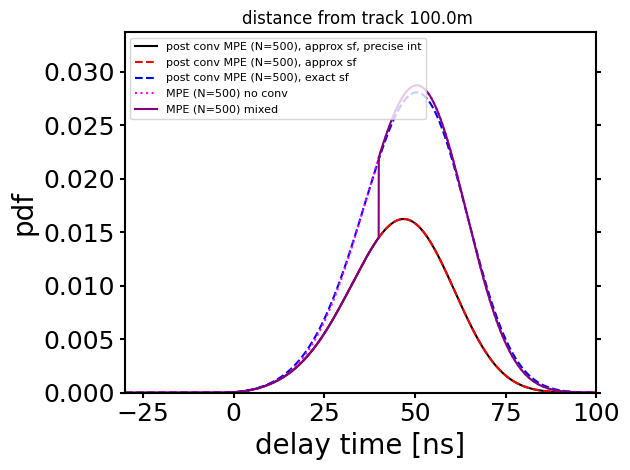

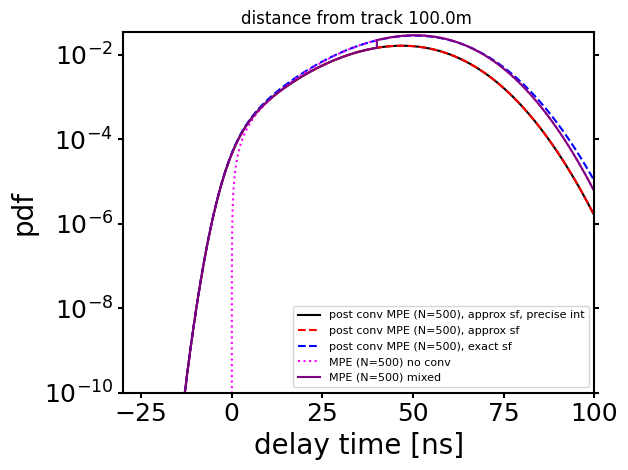

0.574038957474492


In [31]:
from matplotlib.pyplot import cm

n_p = 500

fig, ax = plt.subplots()
xvals = np.linspace(-30, 1000, 100000)

y_max = 0

#ys3 = convolved_post_mpe_exact_qdx_v1d_x(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0))
#plt.plot(xvals, ys3, label=f'post conv MPE (N={n_p:.0f}), exact sf', color='red', linestyle='solid', zorder=-5)
#y_max = np.amax([y_max, np.nanmax(ys3)])
#print(ys[:10])

y_max = 0
ys4 = convolved_post_mpe_approx2_v1d_x(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0))
plt.plot(xvals, ys4, label=f'post conv MPE (N={n_p:.0f}), approx sf, precise int', color='black', linestyle='solid')
y_max = np.amax([y_max, np.nanmax(ys4)])

ys1 = convolved_post_mpe_approx_v1d_x(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0))
plt.plot(xvals, ys1, label=f'post conv MPE (N={n_p:.0f}), approx sf', color='red', linestyle='dashed')
y_max = np.amax([y_max, np.nanmax(ys1)])

ys2 = convolved_post_mpe_exact_v1d_x(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0))
plt.plot(xvals, ys2, label=f'post conv MPE (N={n_p:.0f}), exact sf', color='blue', linestyle='dashed')
y_max = np.amax([y_max, np.nanmax(ys2)])

ys5 = mpe_pdf(xvals, mix_probs, g_a, g_b, n_p)
plt.plot(xvals, ys5, label=f'MPE (N={n_p:.0f}) no conv', color='magenta', linestyle='dotted')

ys6 = combined_v1d_x(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0))
plt.plot(xvals, ys6, label=f'MPE (N={n_p:.0f}) mixed', color='purple', linestyle='solid')

plot_args = {'xlim':[-30, 100],
                     'ylim':[0.0, 1.2*y_max],
                     #'ylim':[0.0, 0.5],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}

adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.title(f"distance from track {dist:.1f}m ")
plt.tight_layout()
plt.legend(fontsize=8)
plt.show()


fig, ax = plt.subplots()


#plt.plot(xvals, ys3, label=f'post conv MPE (N={n_p:.0f}), exact sf', color='red', linestyle='solid', zorder=-5)
plt.plot(xvals, ys4, label=f'post conv MPE (N={n_p:.0f}), approx sf, precise int', color='black', linestyle='solid')
plt.plot(xvals, ys1, label=f'post conv MPE (N={n_p:.0f}), approx sf', color='red', linestyle='dashed')
plt.plot(xvals, ys2, label=f'post conv MPE (N={n_p:.0f}), exact sf', color='blue', linestyle='dashed')
plt.plot(xvals, ys5, label=f'MPE (N={n_p:.0f}) no conv', color='magenta', linestyle='dotted')
plt.plot(xvals, ys6, label=f'MPE (N={n_p:.0f}) mixed', color='purple', linestyle='solid')


plot_args = {'xlim':[-30, 100],
                     'ylim':[1.e-10, 1.2*y_max],
                     #'ylim':[0.0, 0.5],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}

adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.title(f"distance from track {dist:.1f}m ")
plt.tight_layout()
plt.yscale('log')
plt.legend(fontsize=8)
plt.show()

dx = np.ones_like(ys4) * (xvals[1] - xvals[0])
print(np.sum(dx * ys4))

In [77]:
print(mpe_pdf(-10, mix_probs, g_a, g_b, 2000))

0.0


In [36]:
%timeit convolved_post_mpe_approx2_v1d_x(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0))

24.1 ms ± 3.85 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [37]:
%timeit combined_v1d_x(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0))

30.8 ms ± 14.4 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)
